In [1]:
# !pip install --user pmdarima

In [2]:
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
plt.rcParams['figure.figsize'] = (15, 6)  # overwrite the default figure size
plt.rcParams['axes.grid'] = True          # add the grid lines by default

# Temperatures in Eskdalemuir
We start by loading the Eskdalemuir data, which we have already used this weeek, and plot the time series again.

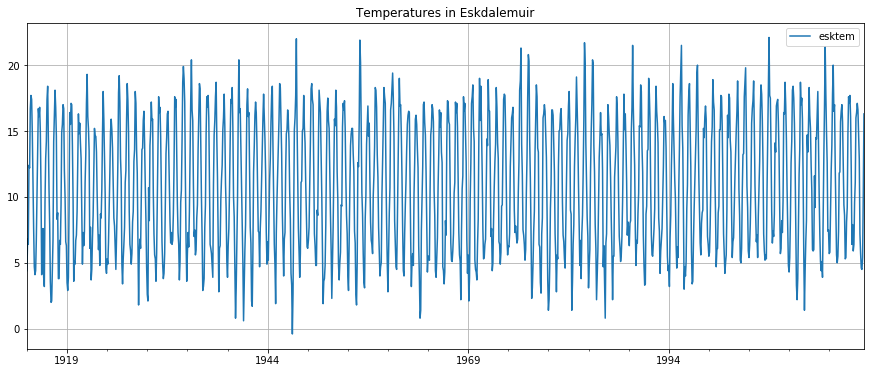

In [4]:
df = pd.read_csv("../../data/week2/esktem.csv", index_col=0, parse_dates=True)
df.plot(title="Temperatures in Eskdalemuir")

esktem= df.esktem.values

Next, we have to construct the covariate matrix containing the linear trend and the harmonic terms for the seasonal effect.

In [5]:
start = 1914
num = df.shape[0]
stop = start + (num-0.5)/12
t = np.arange(start, stop, 1/12)

exog = pd.DataFrame({
    't': t,
    'sin': np.sin(2*np.pi*t),
    'cos': np.cos(2*np.pi*t)
})

exog.head()

,t,sin,cos
0,1914.000000,1.138502e-13,1.000000e+00
1,1914.083333,5.000000e-01,8.660254e-01
2,1914.166667,8.660254e-01,5.000000e-01
3,1914.250000,1.000000e+00,2.449494e-12
4,1914.333333,8.660254e-01,-5.000000e-01


We can now use the function `auto_arima` to search for the best model.

In [6]:
models = pm.auto_arima(
    esktem,  
    seasonal=False,   
    exogenous=exog.values,
    
    trace=True,  # print models that are being tried
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True,  # don't want convergence warnings
    return_valid_fits=True,  # to return all valid models, so we can select the ARMA(2,2)
)  

model = [m for m in models if m.order==(2,0,2)][0]   # selecting the ARMA(2,2) to be consistent with R code
model.summary()

Fit ARIMA: order=(2, 0, 2); AIC=4395.239, BIC=4441.439, Fit time=1.698 seconds
Fit ARIMA: order=(0, 0, 0); AIC=4469.696, BIC=4495.362, Fit time=0.029 seconds
Fit ARIMA: order=(1, 0, 0); AIC=4392.261, BIC=4423.061, Fit time=0.197 seconds
Fit ARIMA: order=(0, 0, 1); AIC=4400.031, BIC=4430.831, Fit time=0.206 seconds
Fit ARIMA: order=(2, 0, 0); AIC=4392.824, BIC=4428.757, Fit time=0.401 seconds
Fit ARIMA: order=(1, 0, 1); AIC=4392.602, BIC=4428.535, Fit time=0.409 seconds
Fit ARIMA: order=(2, 0, 1); AIC=4391.058, BIC=4432.125, Fit time=3.488 seconds
Fit ARIMA: order=(3, 0, 1); AIC=4395.113, BIC=4441.313, Fit time=0.800 seconds
Fit ARIMA: order=(3, 0, 2); AIC=4397.166, BIC=4448.499, Fit time=1.563 seconds
Total fit time: 8.806 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1253
Model:                     ARMA(2, 2)   Log Likelihood               -2188.620
Method:                       css-mle   S.D. of innovations              1.388
Date:                Sun, 02 Feb 2020   AIC                           4395.239
Time:                        16:42:26   BIC                           4441.439
Sample:                             0   HQIC                          4412.605
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.2387      3.592     -1.737      0.083     -13.278       0.801
x1             0.0087      0.002      4.777      0.000       0.005       0.012
x2            -0.4756      0.070     -6.835      0.000      -0.612      -0.339
x3            -6.6715      0.070    -95.872      0.000      -6.808      -6.535
ar.L1.y       -0.3458      0.288     -1.203      0.229      -0.909       0.218
ar.L2.y        0.3535      0.112      3.145      0.002       0.133       0.574
ma.L1.y        0.5861      0.289      2.027      0.043       0.019       1.153
ma.L2.y       -0.1887      0.107     -1.758      0.079      -0.399       0.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2625           +0.0000j            1.2625            0.5000
AR.2            2.2407           +0.0000j            2.2407            0.0000
MA.1           -1.2239           +0.0000j            1.2239            0.5000
MA.2            4.3297           +0.0000j            4.3297            0.0000
-----------------------------------------------------------------------------
"""

Next we plot the linear trend and overlay the partial residuals (i.e. we remove the estimated seasonal effect from the temperatures to obtain what is effectively a temperature anomaly).

In [7]:
# naming the parameters for convenience
params = pd.Series(
    model.params().copy(), 
    index=['const', 't',  'sin', 'cos', 'ar1', 'ar2', 'ma1', 'ma2']
)
params

const   -6.238682
t        0.008725
sin     -0.475579
cos     -6.671491
ar1     -0.345818
ar2      0.353498
ma1      0.586097
ma2     -0.188711
dtype: float64

In [8]:
# To set the parameters exactly as the output from the R code set PARAMS_AS_R=True
PARAMS_AS_R = False
if PARAMS_AS_R:
    params[:] = [-6.1992,  0.0087,  -0.4756, -6.6714, -0.2980,  0.3394,  0.5385, -0.1873]

In [9]:
trend_effect = params['const'] + t*params['t']
seasonal_effect = params['sin']*np.sin(2*np.pi*t) + params['cos']*np.cos(2*np.pi*t) 

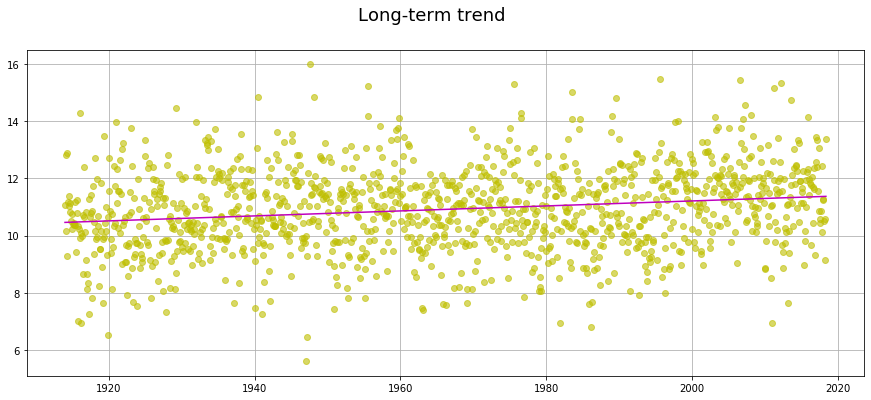

In [10]:
y_points = esktem - seasonal_effect
y_line = trend_effect

fig, ax = plt.subplots()
ax.plot(t, y_points, 'yo', alpha=0.6)
ax.plot(t, y_line, 'm')
ax.figure.suptitle("Long-term trend", fontsize=18);

Finally we plot the seasonal effect and overlay the partial residuals (this time we remove the long-term trend).

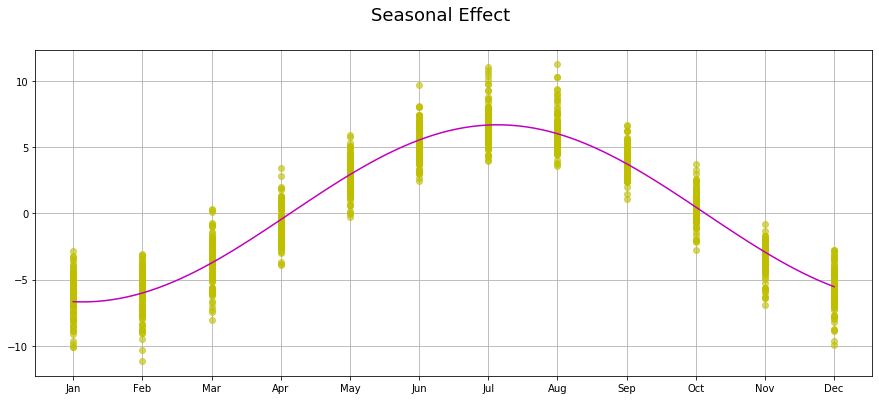

In [11]:
t_mod = (t.round(4) % 1)
y_points = esktem - trend_effect
tt = np.linspace(0, 1-1/12, 100)
y_line = params['sin']*np.sin(2*np.pi*tt) + params['cos']*np.cos(2*np.pi*tt) 

fig, ax = plt.subplots()
ax.plot(t_mod, y_points, 'yo', alpha=0.6)
ax.plot(tt, y_line, 'm')
ax.set_xticks(t_mod[:12])
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May", "Jun", "Jul", "Aug","Sep","Oct", "Nov","Dec"])
ax.figure.suptitle("Seasonal Effect", fontsize=18);